# OPEN DATA BATTLE: **ПРОГНОЗИРОВАНИЕ ОШИБОК МОДЕЛИ**

---
## Содержание

* [Импорт модулей и функций](#Импорт-модулей-и-функций)
* [Подготовка данных: обработка пропусков, стандартизация](#Подготовка_данных:_обработка_пропусков,_стандартизация])
* [Задача классификации: прогнозирование flg_90_12_add](#Задача_классификации:_прогнозирование_flg_90_12_add)
* [Задача регрессии: прогнозирование ERROR](#Задача_регрессии:_прогнозирование_ERROR)
* [Объединение прогнозов](#Объединение_прогнозов)
---

## Импорт модулей и функций

In [3]:
import random
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

## Подготовка данных: обработка пропусков, стандартизация

**data** – исходные данные: 1898 признаков и поле *flg_90_12_add (0, 1)* - целевое для модели банка  
**model** - спрогнозированные моделью банка вероятности дефолта (flg_90_12_add=1) для примеров в *data*  

In [4]:
data = pd.read_csv('_data/data.csv', sep=',')
model = pd.read_csv('_data/model.csv', sep=',')

data = pd.merge(data, model, on='incident') # добавление поля PD (probability of default)
data['ERROR'] = abs(data['PD']-data['flg_90_12_add']) # расчет ERROR (целевое поле задачи)

**realtest** – примеры с пропусками в целевом классе (примеры для сабмита)    
**data** - примеры для обучения и валидации модели прогнозирования ошибок модели банка

In [5]:
realtest = data[data['flg_90_12_add'].isnull()]  # submit-set
data = data[data['flg_90_12_add'].notnull()]  # train-set

print(f'train-set: {data.shape[0]} примеров')
print(f'submit-set: {realtest.shape[0]} примеров',)

train-set: 81617 примеров
submit-set: 1000 примеров


<AxesSubplot:ylabel='Frequency'>

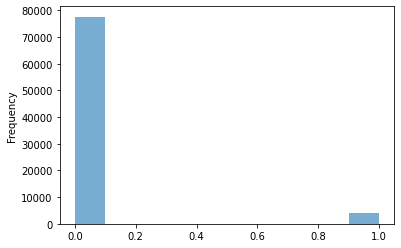

In [29]:
# Наблюдается сильная разбалансировка классов
data['flg_90_12_add'].plot.hist(alpha=0.6)

<AxesSubplot:ylabel='Frequency'>

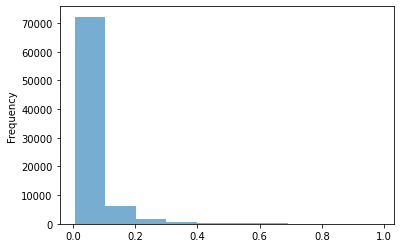

In [13]:
# Практически для всех примеров модель банка прогнозирует класс 0 (вероятности < 0.5)
data['PD'].plot.hist(alpha=0.6)

**Обработка пропусков в данных и скалирование**

Удаление из data и realtest столбцов с количеством пропусков > 50%  
Удаление из data и realtest строк с количеством пропусков > 50%  
Замена в data и realtest пропусков средними по полю значениями

In [6]:
data_cleaned = data.dropna(thresh=0.5*len(data), axis=1)
data_cleaned = data_cleaned.dropna(thresh=0.5*len(data_cleaned.columns), axis=0)

cols = data_cleaned.columns[3:-2] # только столбцы-признаки

scaler = MinMaxScaler()
scaler.fit(data_cleaned[cols])

data_scaled = scaler.transform(data_cleaned[cols])
data_scaled = pd.DataFrame(data_scaled, columns=cols, index=data_cleaned.index)

realtest_scaled = scaler.transform(realtest[cols])
realtest_scaled = pd.DataFrame(realtest_scaled, columns=cols)

for col in cols:
    v = data_scaled[col].mean()
    data_scaled[col].fillna(v, inplace=True)
    realtest_scaled[col].fillna(v, inplace=True)

print(f'data: {data.shape[1]} признаков --> data_scaled: {data_scaled.shape[1]} признаков')
print(f'data: {data.shape[0]} примеров --> data_scaled: {data_scaled.shape[0]} примеров')

data: 1912 признаков --> data_scaled: 416 признаков
data: 81617 примеров --> data_scaled: 71089 примеров


## Задача классификации: прогнозирование flg_90_12_add
Целевая переменная - flg_90_12_add (0 - "не дефолт", 1 - "дефолт")  

Генерация нелинейных признаков  
Балансировка классов с применением SMOTE  
Прогнозирование моделью RandomForestClassifier

#### Генерация нелинейных признаков  
Так как все признаки анонимизированы, невозможно сделать предположения о том, какие из них следует  
использовать для feature engineering. Поэтому выбирается некоторое количество случайных признаков  
Новые признаки представляют собой произведение i-го и j-го признаков из списка rnd_cols

In [7]:
random.seed(42)
rnd_cols = random.sample(list(cols), 5)
rnd_cols

['Feature_1247',
 'Feature_38',
 'Category_Feature_12',
 'Feature_1780',
 'Feature_491']

In [8]:
# Создание новых признаков в data 

new_cols = []
new_cols_name = []

for i in range(len(rnd_cols)):
    for j in range(i+1, len(rnd_cols)):
        
        xixj = str(rnd_cols[i]) + str(rnd_cols[j])
        new_cols.append(data_scaled[rnd_cols[i]] * data_scaled[rnd_cols[j]])
        new_cols_name.append(xixj)

new_cols_df = pd.concat(new_cols, axis=1)
new_cols_df.columns = new_cols_name
data_scaled_ex = pd.concat([data_scaled, new_cols_df], axis=1)

print(f'data_scaled_ex: {data_scaled_ex.shape[1]} признаков')

data_scaled_ex: 426 признаков


In [9]:
# Создание новых признаков в realtest

new_cols = []
new_cols_name = []

for i in range(len(rnd_cols)):
    for j in range(i+1, len(rnd_cols)):
        xixj = str(rnd_cols[i]) + str(rnd_cols[j])
        new_cols.append(realtest_scaled[rnd_cols[i]] * realtest_scaled[rnd_cols[j]])
        new_cols_name.append(xixj)

new_cols_df = pd.concat(new_cols, axis=1)
new_cols_df.columns= new_cols_name
realtest_scaled_ex = pd.concat([realtest_scaled, new_cols_df], axis=1)

print(f'realtest_scaled_ex: {realtest_scaled_ex.shape[1]} признаков')

realtest_scaled_ex: 426 признаков


#### Разбиение на train и test. Балансировка классов с применением SMOTE

In [10]:
X = data_scaled_ex
Y = data_cleaned['flg_90_12_add']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)

print(f'train: {X_train.shape[0]} примеров')
print(f'test: {X_test.shape[0]} примеров')

train: 67534 примеров
test: 3555 примеров


In [40]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'После балансировки:\nКласс 0: {y_train_resampled.value_counts()[0]} примеров')
print(f'Kласс 1: {y_train_resampled.value_counts()[1]} примеров')

После балансировки:
Класс 0: 64369 примеров
Kласс 1: 64369 примеров


#### Обучение RandomForestClassifier и оценка качества прогноза

Процедура подбора параметров *k*, *min_samples_leaf* и *n_estimators* стандартна и поэтому здесь не приводится.  
Парметры выбирались по обеспечиваемому ими сочетанию значений метрик *f1*, *recall* и *precision* при условии некоторых  
ограничений на вычислительные ресурсы. Другие параметры модели *RandomForestClassifier* были оставлены дефолтными.

In [41]:
k = 120
min_samples_leaf = 3
n_estimators = 50

pipeline = Pipeline([('chi',  SelectKBest(chi2, k=k)),
                     ('clf', RandomForestClassifier(min_samples_leaf=min_samples_leaf,
                                                    n_estimators = n_estimators))])

clf_model = pipeline.fit(X_train_resampled, y_train_resampled)

Ориентироваться на Accuracy не имеет смысла - в тестовой выборке подавляющее большинство наблюдений принадлежит классу 0. Значения recall и f1  
хотя совсем небольшие в общем смысле, но все же лучше, чем у модели банка. Неплохое значение precision говорит о том, что если модель и помечает  
наблюдение как принадлежащее классу 1, то делает это только в случае сильной "уверенности". Это как раз то, что нужно - можно "надежно" определить  
примеры с классом 1 и заведомо продекларировать им высокую ошибку модели банка (так как вероятнее всего она на них сильно ошибется).  

In [58]:
y_pred_proba = clf_model.predict_proba(X_test)
y_pred = clf_model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
print(f'Recall = {recall_score(y_test, y_pred)}')
print(f'Precision = {precision_score(y_test, y_pred)}')
print(f'F1 = {f1_score(y_test, y_pred)}')

Accuracy = 0.9521800281293952
Recall = 0.04819277108433735
Precision = 0.4
F1 = 0.08602150537634409


Убеждаемся, что модель редко ошибается, прогнозируя класс 1 с высокой вероятностью (например, большей чем 0.65).  
В шести примерах модель "уверенно" спрогнозировала класс 1, из них - в пяти она не ошиблась.

In [61]:
for i in range(0, len(y_pred)): # для каждого примера в тестовой выборке

    if y_pred[i]==1 and y_pred_proba[i][1] > 0.65: # если модель спрогнозировала класс 1 
                                                   # и уверена в прогнозе более, чем на 65% 

        print(y_pred_proba[i][1], y_pred[i] == np.array(y_test)[i]) # вывести, верно ли она определила метку класса

0.6842460317460318 True
0.6673784461152882 False
0.6931428571428572 True
0.7058571428571428 True
0.8548571428571428 True
0.8148809523809523 True


## Задача регрессии: прогнозирование ERROR

Целевая переменная - ERROR (ошибка модели банка)  

Прогнозирование моделью RandomForestRegressor  
Обучение только на примерах с flg_90_12_add=0

#### Разбиение на test и train

In [63]:
data_scaled['flg'] = data_cleaned['flg_90_12_add']
data_scaled['ERROR'] = data_cleaned['ERROR']

train, test = train_test_split(data_scaled, test_size=0.05, random_state=42)

train = train[train['flg']==0] # Обучение только на классе 0

X_train = train[cols] # признаки из множества cols
X_test = test[cols]
y_train = train['ERROR'] # целевая перменная
y_test = test['ERROR']

print(f'train: {X_train.shape[0]} примеров')
print(f'test: {X_test.shape[0]} примеров')

train: 64369 примеров
test: 3555 примеров


#### Обучение RandomForestRegressor и оценка качества прогноза

Параметры *min_samples_leaf* и *n_estimators* подбирались по минимуму ошибки MAE (по условию кейса).  
Основной вклад в ошибку вносят неверно предсказанные метки на миноритарном классе (1 - p(class=0))

In [65]:
min_samples_leaf = 10
n_estimators = 15

rgs_model = RandomForestRegressor(min_samples_leaf=min_samples_leaf, 
                              n_estimators = n_estimators)

rgs_model = rgs_model.fit(X_train, y_train)

In [67]:
y_pred = model.predict(X_test)

print(f'MAE = {mae(y_test, y_pred)}')

MAE = 0.058062174229535767


## Объединение прогнозов

В качестве прогноза берется прогноз ошибки y_pred, но в тех примерах, для которых модель  
классификации уверено определяет класс 1, прогнозируемая ошибка насильно ставится высокой

Комбинированный прогноз позволил снизить MAE c 0.05806 до 0.05740 (существенный выигрыш в данной задаче)

**y_pred_proba** - прогнозные вероятности классов 0/1 (задача классификации)  
**y_pred** - прогнозные значения ERROR модели банка (задача регрессии)

In [81]:
result_predict = []

for i in range(len(y_pred_proba)):

    if y_pred_proba[i][1] > 0.65: # если модель классификации спрогнозировала класс 1 
                                  # и уверена в прогнозе более, чем на 65% 

        result_predict.append(y_pred_proba[i][1]) # прогнозное значение ERROR равно вероятности класса 1
                                                  # (полагаем, что модель банка в этом наблюдении сильно ошибется)

    else: result_predict.append(y_pred[i]) # иначе прогноз ERROR - прогноз модели регрессии

print(f'MAE = {mae(y_test, result_predict)}')

MAE = 0.05740487479204556
